# Fake News Classification using Long Short-Term Memory Models
With the ubiquity of the internet, social media, and the rise of Artificial Intelligence in the global sphere with Large language models such as GPT-4, fake news and misinformation has become an increasingly large and serious problem. Fake news is now harder to detect than it was in the past, with new and creative methods to generate information such as deepfake images and even artificially generated audio.


In this program, I hope to create a functioning Fake News Classifier using Long Short Term Memory Models that can effectively classify news articles as Fake or Real.



For any deep learning model, a dataset to initially train on and validate is necessary. I am going to be using the "Fake and Real News" dataset from George McIntire. This is a compilation of different news articles labeled either FAKE or REAL; the features include the title of the article and the actual article itself.

Dataset Source: https://github.com/GeorgeMcIntire/fake_real_news_dataset/blob/main/fake_and_real_news_dataset.csv



---



I'm importing some necessary models to begin the project. They include deep learning libraries such as tensorflow, transformers and keras, pandas and numpy for data analysis and manipulation, matplotlib and seaborn for data visualization, nltk for Natural Language Processing, and math for some useful functions.

In [4]:
import tensorflow as tf
import keras
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import sequence

import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import math

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter

import warnings

In [5]:
sns.set_style("dark")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading in the dataset and doing some basic data cleaning and formatting



In [6]:
df = pd.read_csv('/content/fake_and_real_news_dataset.csv')

The idd column is unnecessary for our purposes, we can just use the index column as IDs to locate information and entries.

In [7]:
df.drop('idd', axis=1, inplace=True)

In [8]:
# The label column is currently of type String, converting it into floats for our model.
df['label'] = np.where(df['label'] == 'REAL', 1.0, 0.0)

In [9]:
df.head()

,title,text,label
0,‘A target on Roe v. Wade ’: Oklahoma bill maki...,UPDATE: Gov. Fallin vetoed the bill on Friday....,1.0
1,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,1.0
2,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",1.0
3,Grand jury in Texas indicts activists behind P...,A Houston grand jury investigating criminal al...,1.0
4,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,1.0


In [10]:
# Checking for any NaN values
print(str(df.isna().sum() )+ '\n\n\n')

df[df['title'].isna()]

title    1
text     0
label    0
dtype: int64





,title,text,label
988,NaN,A verdict in 2017 could have sweeping conseque...,1.0


In [11]:
df.dropna(inplace=True)
df.isna().sum()

title    0
text     0
label    0
dtype: int64

---

# Data Exploration

In this section, we delve deep into our dataset, uncovering patterns and insights. Data exploration is essential for understanding the data's nuances and spotting trends, anomalies, and relationships. It lays the foundation for reliable analyses and helps identify and fix data quality issues. This exploration phase is vital for making informed decisions and drawing meaningful conclusions from the data.

In [12]:
# Creating a copy we can manipulate for data exploration, leaving the one we are using for training untouched.
explore_df = df.copy()

In [13]:
# Dividing data into fake and real makes data exploration easier.
fake = explore_df[explore_df['label'] == 0.0]
real = explore_df[explore_df['label'] == 1.0]

Let's look at the distribution of real and fake values.

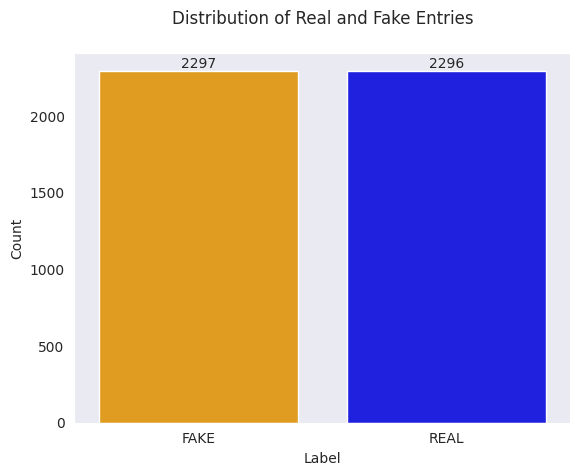

In [14]:
color_mapping = {
    '0.0': 'orange',
    '1.0': 'blue'
}

ax = sns.barplot(data=explore_df['label'].value_counts(),
                 palette=color_mapping,
                 orient='v')

ax.set_xticklabels(['FAKE', 'REAL'])

for i in ax.containers:
  ax.bar_label(i,)

plt.title("Distribution of Real and Fake Entries\n")
plt.xlabel("Label")
plt.ylabel("Count")

plt.show()

Looking at the length distribution of fake and real news

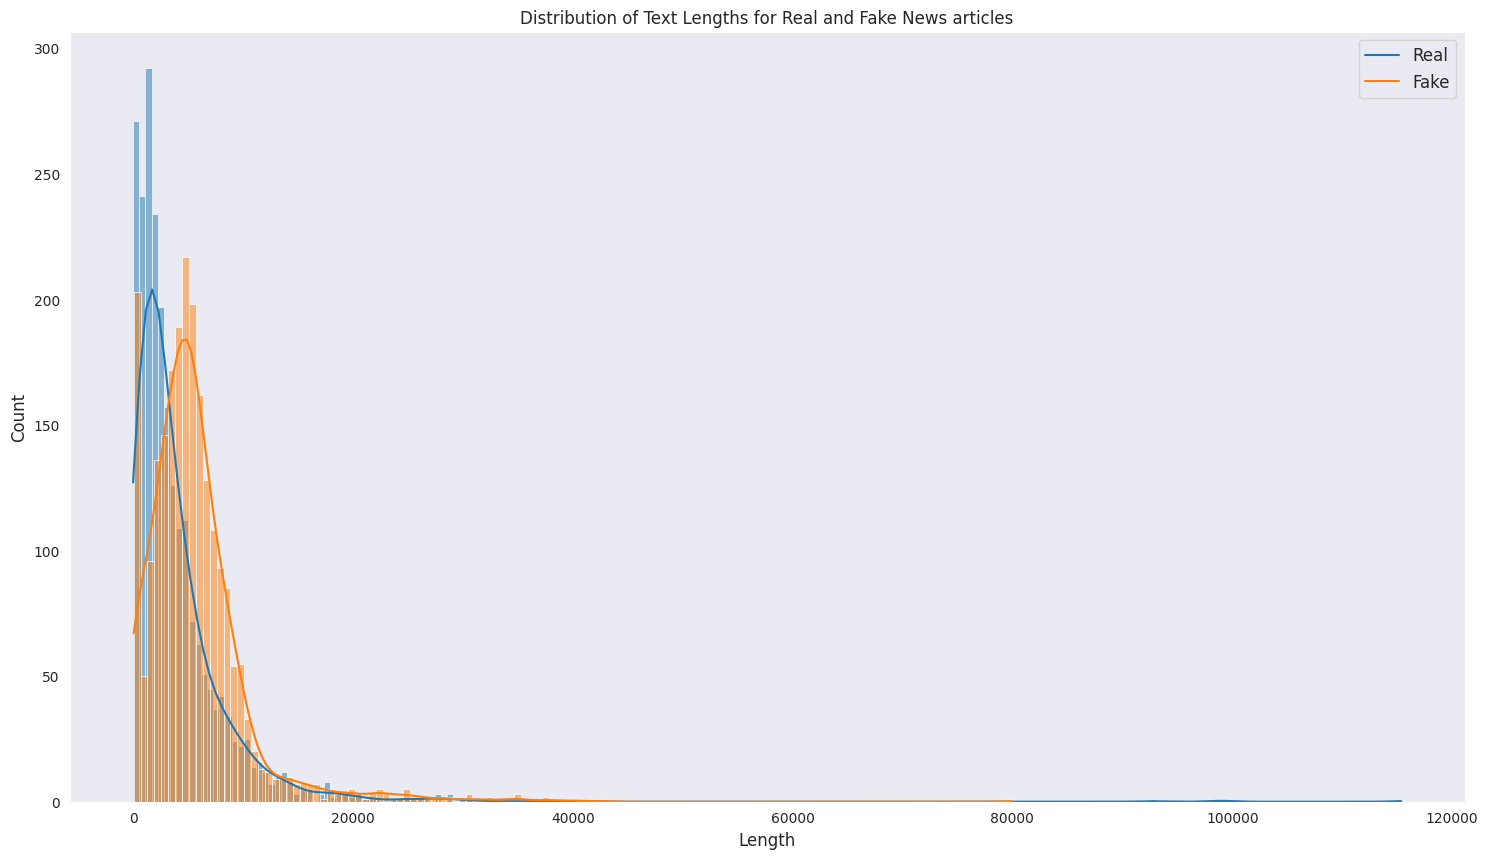

In [15]:
fake['length'] = fake.loc[:,'text'].apply(len)
real['length'] = real.loc[:,'text'].apply(len)

plt.figure(figsize=(18, 10))

plt.title("Distribution of Text Lengths for Real and Fake News articles", fontsize='large')
plt.xlabel('Length', fontsize='large')
plt.ylabel('Count', fontsize='large')

sns.histplot(fake['length'], kde=True)
sns.histplot(real['length'], kde=True)


plt.legend(['Real', 'Fake'], fontsize='large', loc='upper right', bbox_to_anchor=(1, 1))
plt.show()

In [16]:
# Looking at the average lengths of texts labeled real vs. texts labeled fake
print("--------Average Length-------- ")
print(f"Fake: {fake['length'].mean()}")
print(f"Real: {real['length'].mean()}")

--------Average Length-------- 
Fake: 4032.5037004788855
Real: 5693.293554006968


In [17]:
N_MOST_COMMON = 10
N = 2

def remove_stopwords(text):
  words = word_tokenize(text)
  stopwords_english = set(stopwords.words('english'))

  no_stopwords = [word for word in words if word.lower() not in stopwords_english]

  return ' '.join(no_stopwords)

def generate_ngrams(tokens, n):
    return list(ngrams(tokens, n))

combined_real = ' '.join(list(real['text'])).lower()
cleaned_real = remove_stopwords(combined_real)
cleaned_real = re.sub(r'[^\w\s]', '', cleaned_real)

combined_fake = ' '.join(list(fake['text'])).lower()
cleaned_fake = remove_stopwords(combined_fake)
cleaned_fake = re.sub(r'[^\w\s]', '', cleaned_fake)

real_tokens = word_tokenize(cleaned_real)
fake_tokens = word_tokenize(cleaned_fake)

real_ngram_list = generate_ngrams(real_tokens, N)
fake_ngram_list = generate_ngrams(fake_tokens, N)

real_counts = Counter(real_ngram_list)
fake_counts = Counter(fake_ngram_list)

top_real = real_counts.most_common(N_MOST_COMMON)
top_fake = fake_counts.most_common(N_MOST_COMMON)

---

Visualizing all that information to better understand it

In [18]:
top_real = dict(top_real)
top_fake = dict(top_fake)

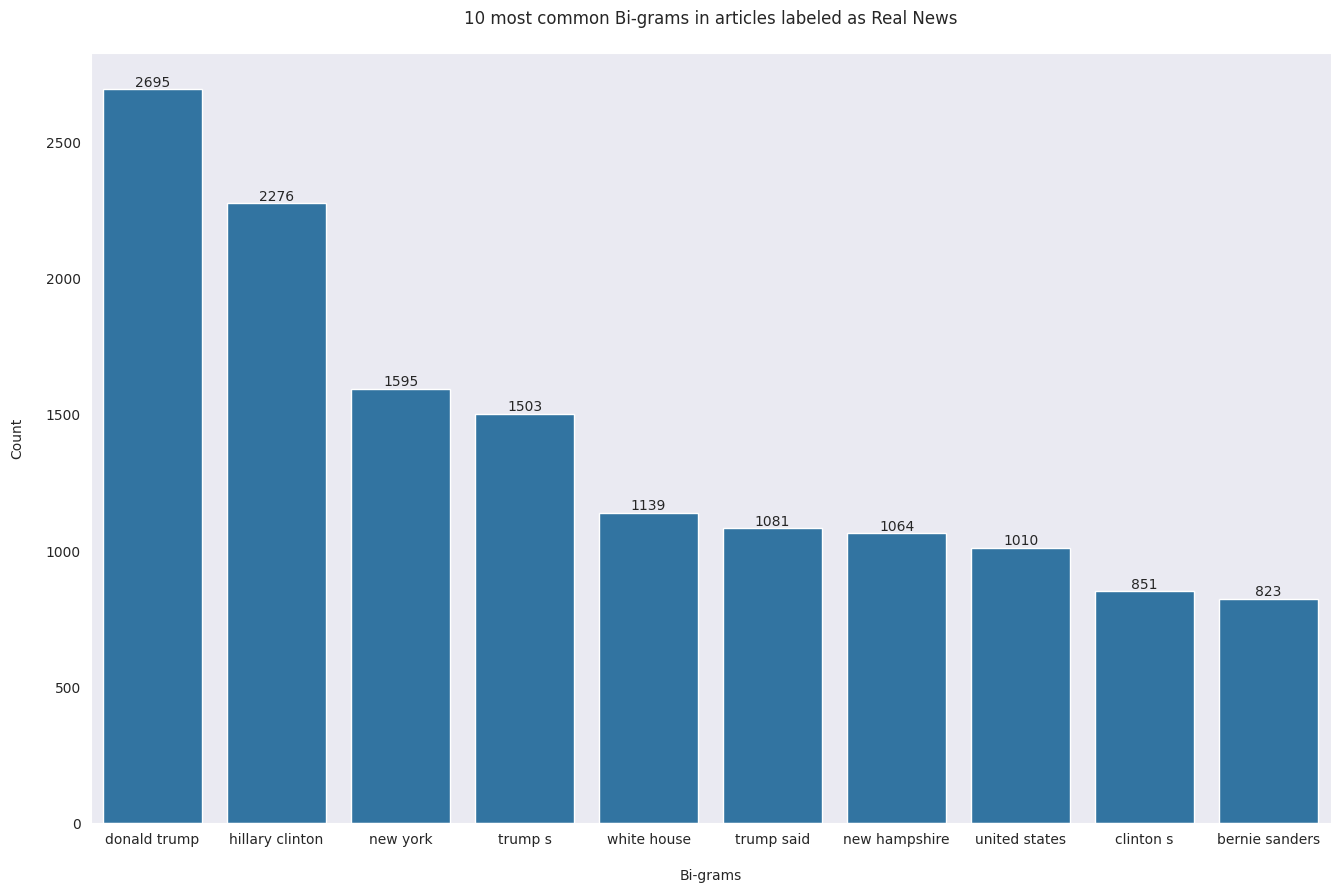

In [19]:
figsize = plt.figure(figsize=(16, 10))
plt.title(f"{N_MOST_COMMON} most common Bi-grams in articles labeled as Real News\n")

plt.xlabel("\nBi-grams")
plt.ylabel("Count\n")

ax = sns.barplot(x=pd.Series(top_real.keys()).apply(lambda x: x[0] + " " + x[1]), y=top_real.values())

for i in ax.containers:
  ax.bar_label(i,)

plt.show()

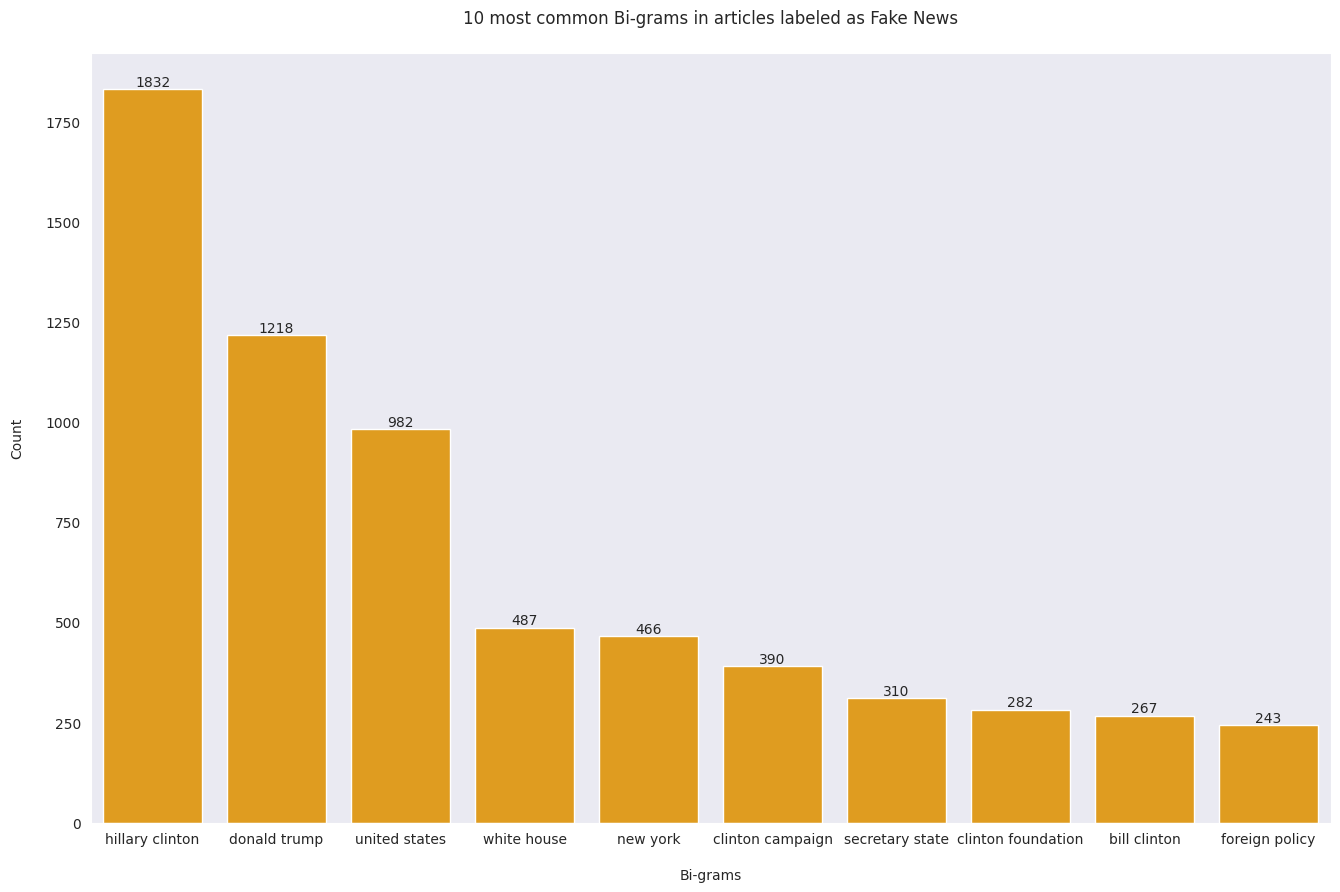

In [20]:
figsize = plt.figure(figsize=(16, 10))
plt.title(f"{N_MOST_COMMON} most common Bi-grams in articles labeled as Fake News\n")

plt.xlabel("\nBi-grams")
plt.ylabel("Count\n")

ax2 = sns.barplot(x=pd.Series(top_fake.keys()).apply(lambda x: x[0] + " " + x[1]), y=top_fake.values(),
            color='orange')

for i in ax2.containers:
  ax2.bar_label(i,)


plt.show()

We can see that many of the most commong bi-grams are shared within both real and fake news. Therefore, it also follows that topic is not necessarily and important feature when it comes to identifying fake or real news, atleast in this dataset. We cannot generalize to all data since this dataset is not representative of the overall population and contains articles from mostly political contexts.

# Analysis and Prediction using LSTMs

Long Short-Term Memory models (or LSTMs for short) are a type of recurrent neural network which are extremely useful in text classification. Their strength lies in the fact that inputs are passed in procedurally. This means that any given text is passed into the network one word at a time, and the output from previous words is passed in as well. That's where the memory aspect of this model comes in. The model "remembers" past inputs and in doing so, it can pick up on patterns with word placement in texts as well as textual context.




LSTMs excel at grasping the sequential structure of text due to their recurrent nature., allowing them to pick up on subtle cues and patterns that indicate misinformation. By analyzing the flow of language over time, LSTMs can effectively distinguish between genuine and fake news, making them a valuable tool in combating misinformation online.


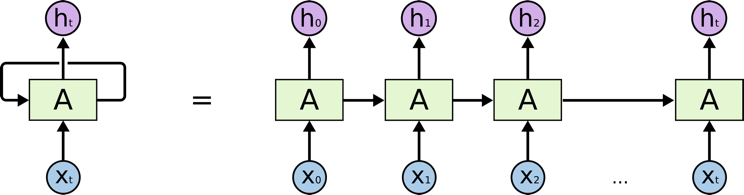


Looking at the diagram above, let's go through an example with the text "My name is Zach".



#### The text is first tokenized and split into an array.
*  In this case: ["My", "name", "is", "Zach"]
* The words are represented as numbers based on a tokenization algorithm, a sample tokenization could be [324, 243, 54, 211].

#### Each token is passed in to the model individually to different cells, and the output of previous tokens is passed into each consequetive cell.
* For example $x_0$ would be 324 and $x_1$ would be 243. The second A cell would take in 243 as input as well as the output from the first A cell where we passed in 324, giving this model is "memory".
* The process would repeat until we reach the end of the sentence, at which point an output would be generated.
---


Machine Learning models require a training set to learn from and generate patterns from, and a test set so we can understand how well the model performs on data it has never seen before (out-of-sample data).

In [21]:
# Defining certain constants to split our data into training and test datasets.
TRAIN_SIZE = 0.8
idx = int(len(df) * TRAIN_SIZE) # The index where we will be splitting is the length * TRAIN_SIZE

# Before we split the data, we shuffle it to make sure that no one set is biased
df = df.sample(frac=1).reset_index().drop('index', axis=1)

train = df.iloc[0:idx]
test = df.iloc[idx:]

In [22]:
# Checking that all our data is split properly
print("Train:", train.index)
print("Train:", test.index)
print("Original Dataset:", df.index)

Train: RangeIndex(start=0, stop=3674, step=1)
Train: RangeIndex(start=3674, stop=4593, step=1)
Original Dataset: RangeIndex(start=0, stop=4593, step=1)


Now that we've cleaned the data to make sure that it is in the right format for our model, looked at some features and gained insights from exploratory data analysis and visualization, it's time to create our deep learning model and train and test it to get predictions.

---

## Text Preprocessing

The first step is to preprocess our text. The process that I am using can be broken down into three main components:
* Removing Stopwords
* Lemmatization
* Tokenization

Stopwords are common words that have little effect on classification. Words like 'and', 'is', 'would', which are common grammatical function words, do not have much meaning that could be used to infer whether a text is fake or real.

Lemmatization is the process of condensing words to their base forms. This could mean removing plurality, tenses, etc.

Finally, perhaps the most important part is tokenization. This is the process of representing text in a quantitative format using an array of floating-point values. The general idea of tokenization is this:

* Each word or important feature is assigned a number based on an already existing word-bank or vocabulary. The number is sometimes random, sometimes based on features of the text such as whether the word in question is at the beginning, middle, or end, or what part of speech the word is. The goal is to encode as much information about the text in question as possible using numbers.

There are several algorithms to tokenize our text. The one we are using is the AutoTokenizer from the HuggingFace transformers library. AutoTokenizer tokenizes text using subword split tokenization. This means that unfamiliar non-base form words are split into different subwords which are then tokenized normally using HuggingFace's vocabulary. For example, the word "annoyingly" might be split into "annoying" and "ly" wihch are then tokenized individually. This makes it so that the model receives the meaning of the word as well as information about the part of speech.





In [23]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
lemma = WordNetLemmatizer()

def preprocess_text(text):
  text = re.sub(r'[^\w\s]', '', text)
  no_stopwords = remove_stopwords(text).split(' ')

  lemmatized = [lemma.lemmatize(word) for word in no_stopwords]
  preprocessed_text = ' '.join(lemmatized)

  return preprocessed_text

# The transformers Tokenizer can only take in text with 512 words. Our articles are thousands of words long so we have to process text in batches.
def tokenize_text(text, batch_size=512, return_type='list'):
  try:
    text = preprocess_text(text).split(' ')
  except:
    print("Error Occured: " + text)
    return

  tokenized = []
  N = math.ceil(len(text) / batch_size)

  start = 0
  end = batch_size
  for i in range(N):
    current_text = ' '.join(text[start:end])
    token = tokenizer(current_text, padding=True, truncation=True)['input_ids']
    tokenized.extend(token)

    try:
      start += batch_size
      end += batch_size
    except:
      end = len(text)
      start += batch_size

  match return_type:
    case "list":
      return tokenized

    case "np":
      return np.array(tokenized)

    case "tf":
      return tf.tensor(tokenized)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Applying our previous tokenize_text function to the train and test data.

In [24]:
train_text = train['text'].apply(tokenize_text)
title_text = train['title'].apply(tokenize_text)

train_text = sequence.pad_sequences(train_text)
title_text = sequence.pad_sequences(title_text)

train_labels = train['label'].tolist()

In [25]:
# Storing the maximum length so we can use it when we preprocess our test data
MAX_TEXT_LENGTH = len(train_text[0])
MAX_TITLE_LENGTH = len(title_text[0])

## Creating and Training the Model

We have now preprocessed both the training and testing data and are now ready to create our model. To do so, I will be using the keras Functional API. As opposed to the Sequential API, the Functional API lets us customize our model much more, which is necessary as we have multiple inputs (title and text).

A brief explanation of how the model works: each input (title and text) is first passed through an Embedding layer for extra tokenization and vectorization. The input is then passed in to an LSTM layer with a 'tanh' activation function. As mentioned before, the LSTM takes in the text individually a word-at-a-time and generates output using the 'tanh' activation function. The Dropout layer helps reduce overfitting by 'cutting' 25% of the connections between the first LSTM and the next. After each input is passed through the Embedding Function and two LSTMs, the resulting output is concatenated. Finally, the outputs are generated using a Dense Layer with one out channel and a sigmoid activation function. We will delve into activation functions and overfitting next.

## Activation Functions

Activation functions are key in neural networks because they introduce non-linearities, enabling the network to grasp intricate patterns in the data. They're applied to the output of each neuron, shaping how information flows through the network. Common activation functions like sigmoid, tanh, ReLU (short for Rectified Linear Unit), and softmax each have their roles in helping the network understand different aspects of the data.

#### Sigmoid
* The sigmoid function converts input values to a value between 0 and 1. It eseentially 'squashes' the data between 0 and 1. This is useful in our output layer as we can interpret the logits.


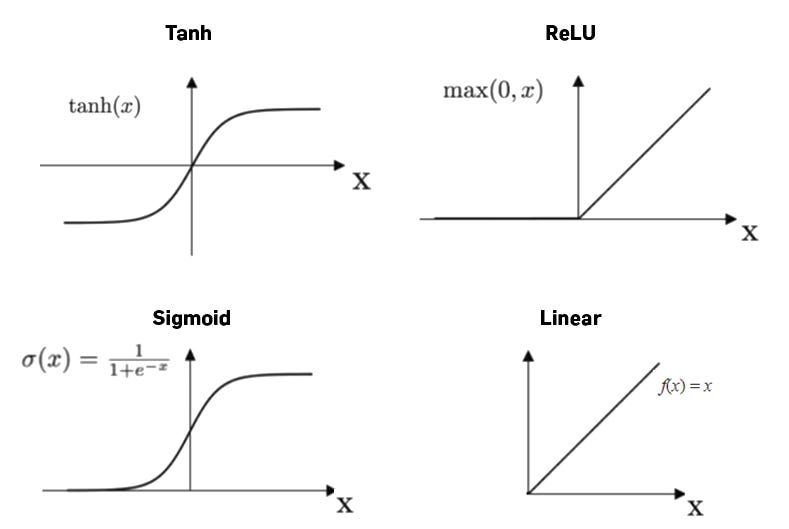

## Overfitting and Underfitting
In machine learning, there are two base metrics to measure how our model performs in a general sense: Bias and Variance

*Bias* represents the error due to overly simplistic assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

*Variance*, on the other hand, represents the error due to too much complexity in the learning algorithm. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

To see whether our model contains high bias/variance, we can look at how it performs on test vs. train data.

1. If the model performs considerably well on train data, but poorly on out-of-sample test data, this could be a sign of high variance. The model models the noise of the training data and poorly generalizes to other data. (Overfitting)

2. If the model performs poorly on train and test data, this is a sign of high bias (underfitting)

![Bias and Variance.webp](
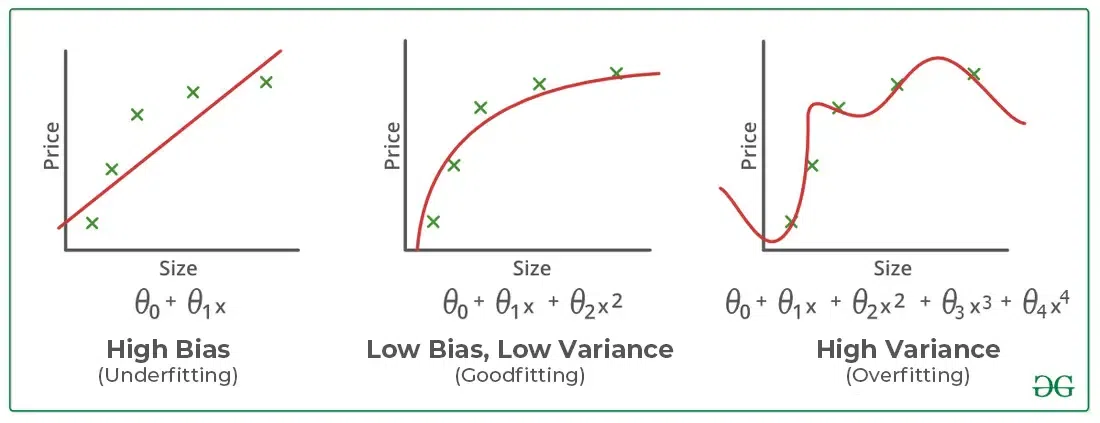)



------


Addressing overfitting often involves techniques like regularization (such as L1 or L2 regularization), dropout, early stopping, or using simpler models. It's essential to strike a balance between bias and variance to build a model that generalizes well to unseen data. The two methods I have used are L2 Regularization and Dropout.

In [26]:
# Defining constants
DROPOUT_PERCENT = 0.25
LSTM_LAYERS = 16
VOCAB_SIZE = 88584
OUTPUT = 1
EPOCHS = 4

In [27]:
# Building our model
input_1 = keras.Input(shape=train_text[0].shape) # input that takes in the text
x = keras.layers.Embedding(VOCAB_SIZE, 64)(input_1)
x = keras.layers.LSTM(LSTM_LAYERS, activation='tanh', kernel_regularizer=regularizers.l2(0.01), return_sequences=True)(x)
x = keras.layers.Dropout(DROPOUT_PERCENT)(x)
x = keras.layers.LSTM(LSTM_LAYERS, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(x)

input_2 = keras.Input(shape=title_text[0].shape) # input that takes in the title
y = keras.layers.Embedding(VOCAB_SIZE, 64)(input_2)
y = keras.layers.LSTM(LSTM_LAYERS, activation='tanh', kernel_regularizer=regularizers.l2(0.01), return_sequences=True)(y)
y = keras.layers.Dropout(DROPOUT_PERCENT)(y)
y = keras.layers.LSTM(LSTM_LAYERS, activation='tanh', kernel_regularizer=regularizers.l2(0.01))(y)

inputs = keras.layers.Concatenate(axis=1)([x, y]) # Combining the results from both inputs
outputs = keras.layers.Dense(OUTPUT, activation='sigmoid')(inputs) # Passing through a dense sigmoid layer

model = keras.Model(inputs=[input_1, input_2], outputs=outputs)

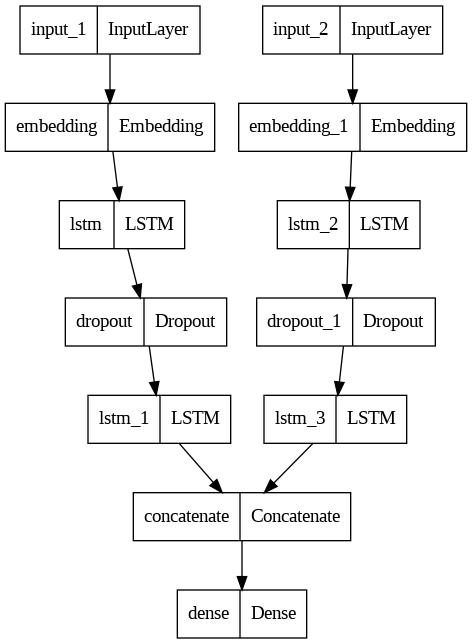

In [28]:
keras.utils.plot_model(model)

In [29]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Training our model for a 4 iterations (or epochs), keeping track of our loss and accuracy for each epoch. We are converting train_labels to a NumPy array to match the train and title text.

In [30]:
hist = model.fit(
    [train_text, title_text], np.array(train_labels),
    epochs=4,
    verbose=1
)

Epoch 1/4
115/115 [==============================] - 104s 797ms/step - loss: 1.4453 - accuracy: 0.7893
Epoch 2/4
115/115 [==============================] - 86s 748ms/step - loss: 0.4465 - accuracy: 0.9219
Epoch 3/4
115/115 [==============================] - 82s 710ms/step - loss: 0.1586 - accuracy: 0.9826
Epoch 4/4
115/115 [==============================] - 88s 767ms/step - loss: 0.0834 - accuracy: 0.9924


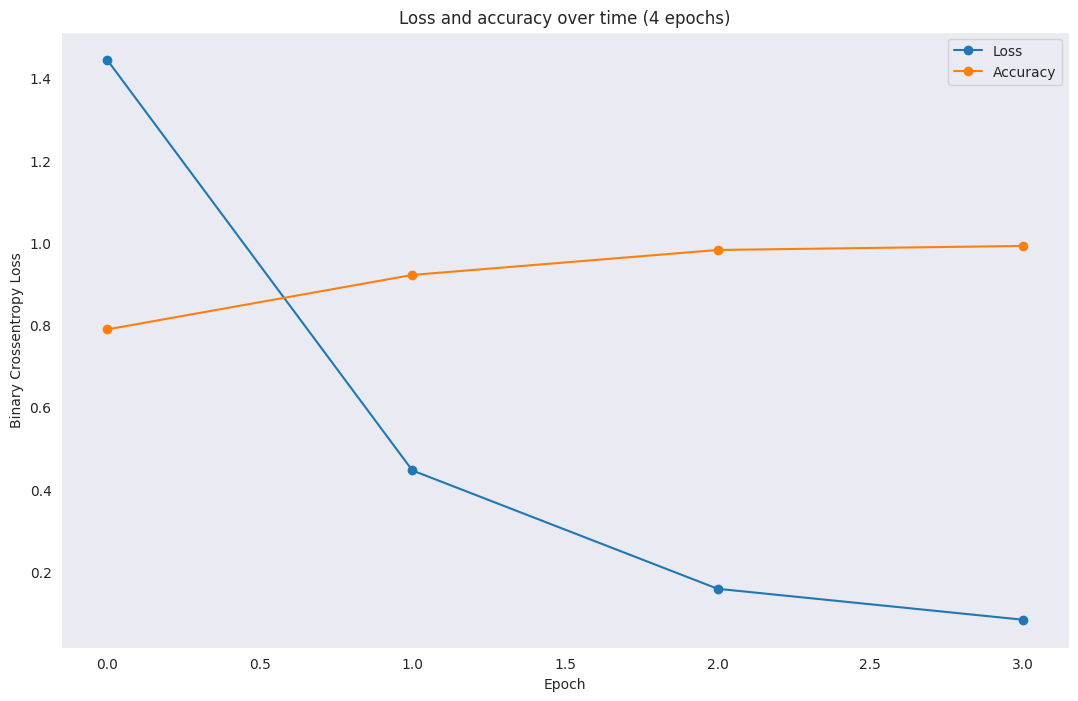

In [31]:
loss_over_time = (hist.history['loss'])
accuracy_over_time = (hist.history['accuracy'])

fig, ax = plt.subplots(figsize=(13, 8))

plt.title("Loss and accuracy over time (4 epochs)")

plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy Loss")

plt.plot(loss_over_time, 'o-')
plt.plot(accuracy_over_time, 'o-')

plt.legend(['Loss', 'Accuracy'])

plt.show()

In [32]:
test_text = test['text'].apply(tokenize_text)
test_text = sequence.pad_sequences(test_text, maxlen=MAX_TEXT_LENGTH)

test_title = test['title'].apply(tokenize_text)
test_title = sequence.pad_sequences(test_title, maxlen=MAX_TITLE_LENGTH)

test_labels = np.array(test['label'])

In [33]:
model.evaluate([test_text, test_title], test_labels)

29/29 [==============================] - 15s 417ms/step - loss: 0.2264 - accuracy: 0.9260


[0.22640587389469147, 0.926006555557251]

Overall, the model performed very well, achieving a near perfect 0.9924 accuracy for the train set and an exceptional 0.9260 for the test set. While these results are very good, it is important to consider other factors. Our dataset only consisted of 5,000 entries, which means that the model might not be as efficient to generalize patterns across the millions of news articles in the internet, which could be a sign of overfitting.

To test this hypothesis, I'm going to load in an entirely different fake news dataset, and evaluate our model's performance on the new test set.

In [34]:
out_sample_test = pd.read_csv('train 2.csv')
out_sample_test = out_sample_test.sample(frac=1).reset_index(drop=True)[:5000]

out_sample_test.drop('author', axis=1, inplace=True)
out_sample_test.dropna(inplace=True)

# The labels are reversed in this new set where 1 is fake and 0 is real, so let's reverse those
out_sample_test['label'] = np.where(out_sample_test.label == 1, 0, 1)

In [35]:
# Preprocessing the text and titles

out_sample_text = out_sample_test['text'].apply(tokenize_text)
out_sample_text = sequence.pad_sequences(out_sample_text, maxlen=MAX_TEXT_LENGTH)

out_sample_title = out_sample_test['title'].apply(tokenize_text)
out_sample_title = sequence.pad_sequences(out_sample_title, maxlen=MAX_TITLE_LENGTH)

out_sample_labels = np.array(out_sample_test['label'])

In [36]:
model.evaluate([out_sample_text, out_sample_title], out_sample_labels)

153/153 [==============================] - 45s 286ms/step - loss: 1.3287 - accuracy: 0.6228


[1.3287341594696045, 0.6227655410766602]

In [37]:
# Saving our model
model.save('fake_news_classifier.keras')

In [38]:
def fake_or_real(title, text):
  title_token = tokenize_text(title, return_type='np')
  text_token = tokenize_text(text, return_type='np')

  title_token = title_token.reshape(-1, len(title_token))
  text_token = text_token.reshape(-1, len(text_token))

  title_token = sequence.pad_sequences(title_token, maxlen=MAX_TITLE_LENGTH)
  text_token = sequence.pad_sequences(text_token, maxlen=MAX_TEXT_LENGTH)

  logits = model.predict([text_token, title_token])
  pred = 0 if logits[0] < 0.50 else 1
  return logits, pred

# Conclusions

While the train and test showed significantly high accuracy, out-of-sample data from a completely new dataset shows a much worse performance at only 0.62 accuracy. This is a surefire sign of overfitting, and this could be due to many different factors.
* Our initial dataset was small in size (only 5000 entries in total), this could lead to not all forms of articles being represented.
* Our model could have been too complex and trained on the noise from our initial datasets.

To better mitigate overfitting, I have used techniques such as L2 regularization as well as adding dropout layers in the model. This reduces the high variance by a degree, however there are still things that could be done to address the issue more thorougly, such as:
* Data augmentation by varying the order of words in the text
* Training on a larger dataset or web-scraping to generate articles from all sources and contexts.


Overall, I'm happy with the results as the model performed well on the dataset, but there was also significant overfitting. It was somewhat mitigated slightly by Dropout Layers and L2 Regularization, (accuracy went from 0.50 to 0.62). but research and work needs to be done in the future to address overfitting in our model completely.

